# Initialization

In [1]:
# Standard Library Imports
import pickle
import gzip
import math
import os
import time
import shutil
import sys
import gc
import traceback
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# Third-Party Library Imports
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc

# PyTorch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
import torch.nn.functional as F

# miniai
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

# Fastcore
from fastcore.test import test_close

# PyTorch settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

# Disable logging warnings
import logging
logging.disable(logging.WARNING)

set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))

In [3]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

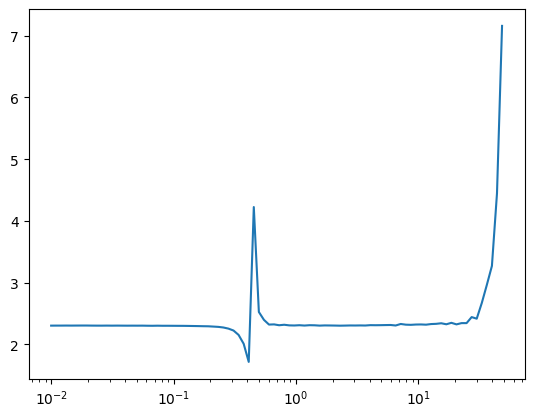

In [4]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.296,1.881,0,train
0.678,0.840,0,eval


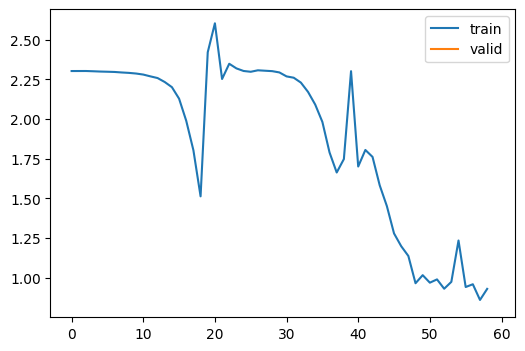

In [6]:
learn.fit(1)

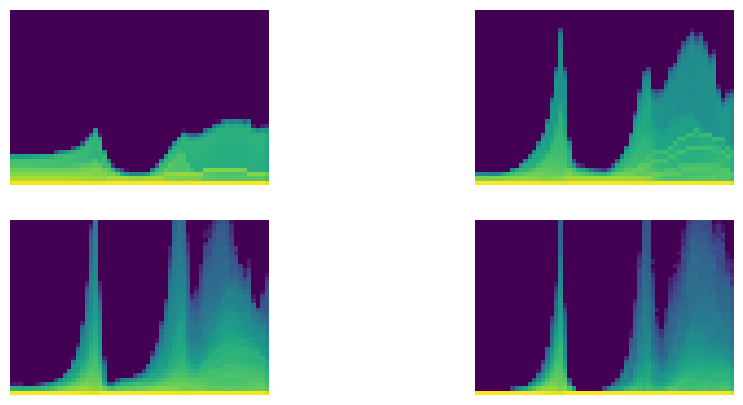

In [7]:
astats.color_dim()

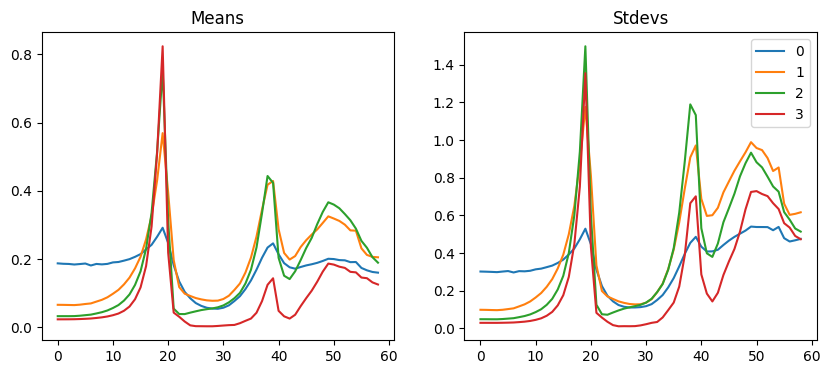

In [8]:
astats.plot_stats()

In [9]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [10]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [11]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

#### The Problem Xavier Initialization Solves:

In deep neural networks, especially those with many layers, the scale of weights can dramatically impact how gradients propagate during backpropagation. If the weights are initialized too large, the gradients may explode, leading to unstable updates. If the weights are initialized too small, gradients may vanish, making it difficult for the network to learn.

Xavier initialization is designed to keep the variance of activations and gradients in a manageable range as they propagate through the network.

#### The Xavier Initialization Formula:

For a neuron with $n_{\text{in}}$ input connections (number of incoming connections), the Xavier initialization sets the weights according to:

$$
W \sim \mathcal{U}\left( -\frac{1}{\sqrt{n_{\text{in}}}}, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

Where:
- $\mathcal{U}$ is the uniform distribution.
- $n_{\text{in}}$ is the number of input neurons to a given layer.
- The weights are sampled from a uniform distribution between $-\frac{1}{\sqrt{n_{\text{in}}}}$ and $\frac{1}{\sqrt{n_{\text{in}}}}$.

Alternatively, for a normal distribution (Gaussian), the weights are initialized as:

$$
W \sim \mathcal{N}\left( 0, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

This ensures that the variance of the activations is controlled across layers and helps prevent gradients from growing too large or too small.

---

#### When to Use Xavier Initialization:

Xavier initialization is typically used for **activation functions like Sigmoid or Tanh**.

---

#### Example in PyTorch:

In PyTorch, you can apply Xavier initialization using the built-in function `torch.nn.init.xavier_uniform_` or `torch.nn.init.xavier_normal_`.

Example code for Xavier initialization:

```python
import torch
import torch.nn as nn

# Example layer
layer = nn.Linear(in_features=256, out_features=128)

# Apply Xavier Uniform initialization
torch.nn.init.xavier_uniform_(layer.weight)

# Or apply Xavier Normal initialization
torch.nn.init.xavier_normal_(layer.weight)

In [12]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ torch.randn(100,100)

x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [13]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.01)

x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [14]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.1)

x[0:5,0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

## Background

#### Variance:
Variance is a measure of variability in a dataset that indicates how far a set of numbers are spread out from their average value (mean). 

Mathematically, for a dataset X with n elements, variance (σ²) is defined as:

σ² = Σ(X - μ)² / n

Where:
- X is each value in the dataset
- μ is the mean of the dataset
- n is the number of values

#### Standard Deviation:
Standard deviation is the square root of variance. It measures the amount of variation or dispersion of a set of values.

Mathematically, standard deviation (σ) is:

σ = √(σ²)

In [15]:
t = torch.tensor([1.,2.,4.,18])

In [16]:
m = t.mean(); m

tensor(6.25)

In [17]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [18]:
(t-m).pow(2).mean()

tensor(47.19)

In [19]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [20]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [21]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

## Covariance

Covariance is a measure of how two variables change together. It helps understand whether an increase in one variable would lead to an increase or decrease in another variable. Let's break it down step by step, increasing the complexity gradually.

- **Positive Covariance:** Variables increase or decrease together.
- **Negative Covariance:** One variable increases, the other decreases.
- **Zero Covariance:** No linear relationship between the variables.

#### Formula

The covariance between two variables $X$ and $Y$ is defined mathematically as:

$$
\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})
$$

Where:

- $X_i$ and $Y_i$ are the data points of the two variables.
- $\bar{X}$ and $\bar{Y}$ are the means of the variables $X$ and $Y$, respectively.
- $n$ is the total number of data points.

#### Relation to Variance

Variance is a special case of covariance where both variables are the same. For a variable $X$, its variance is the covariance of $X$ with itself:

$$
\text{Var}(X) = \text{Cov}(X, X) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

Covariance extends this idea to capture the relationship between two different variables.

#### Covariance Matrix

For multiple variables, the covariance between each pair of variables can be organized into a matrix known as the **covariance matrix**. For random variables $X_1, X_2, \dots, X_n$, the covariance matrix $\Sigma$ is defined as:

$$
\Sigma = \begin{bmatrix}
\text{Cov}(X_1, X_1) & \text{Cov}(X_1, X_2) & \cdots & \text{Cov}(X_1, X_n) \\
\text{Cov}(X_2, X_1) & \text{Cov}(X_2, X_2) & \cdots & \text{Cov}(X_2, X_n) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(X_n, X_1) & \text{Cov}(X_n, X_2) & \cdots & \text{Cov}(X_n, X_n) \\
\end{bmatrix}
$$

This matrix is symmetric because $\text{Cov}(X_i, X_j) = \text{Cov}(X_j, X_i)$.

### Normalization and Correlation

Covariance is not normalized, which means it can have any value depending on the scale of the variables. To create a scale-independent measure, we use the **Pearson Correlation Coefficient**, which is the normalized form of covariance:

$$
\text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

Where $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively. Correlation ranges between -1 and 1, providing a clearer measure of the linear relationship between variables.

#### Geometric Interpretation

In a geometric sense, covariance reflects the angle between vectors representing the variables. If the covariance is positive, the vectors tend to point in the same direction (acute angle), while a negative covariance indicates that the vectors point in opposite directions (obtuse angle). If the covariance is zero, the vectors are orthogonal, meaning there's no linear relationship.

Let's see that in code. So now we need two vectors.

In [22]:
t

tensor([ 1.,  2.,  4., 18.])

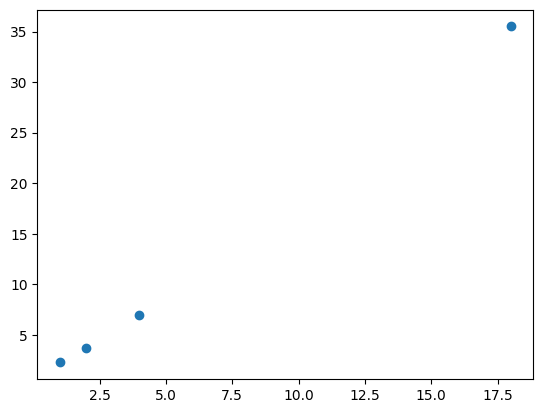

In [23]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [24]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.67,  35.81,  11.57, 275.08])

In [25]:
prod.mean()

tensor(93.53)

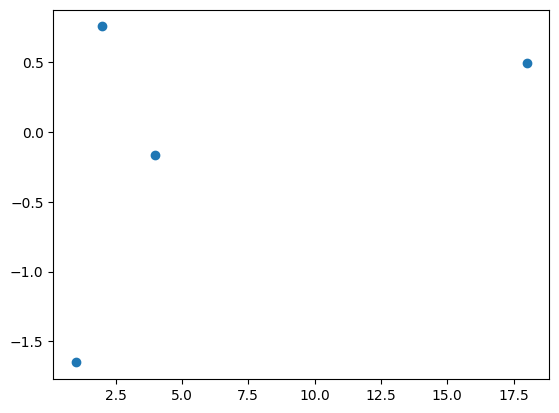

In [26]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [27]:
((t-t.mean())*(v-v.mean())).mean()

tensor(2.91)

In [28]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(2.91)

#### Pearson Correlation Coefficient

In [29]:
cov / (t.std() * v.std())

tensor(0.34)

#### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [30]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.19), tensor(0.96))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [31]:
mean,sqr = 0.,0.

for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()

mean/100, sqr/100

(-0.021637045219540595, 101.61874839782715)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of `a` by one element of `x`. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [32]:
mean,sqr = 0.,0.

for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()

mean/10000, sqr/10000

(-0.003184134499988704, 0.9690546516017775)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product as many times as we want won't overflow or vanish.

## Kaiming/He init

Kaiming Initialization (also known as He Initialization) is a method for initializing the weights of neural networks, particularly deep networks with **ReLU** activation functions. Its goal is to ensure that the weights in each layer maintain the flow of information through the network, without causing vanishing or exploding gradients. It works by setting the initial weights to random values drawn from a distribution with a specific variance that depends on the number of input units in the layer.

#### Formula:
For a layer with \( n \) input units (also called "fan-in"), the weights are initialized by drawing from a normal (or uniform) distribution with variance:

$$
\text{Var}(w) = \frac{2}{n}
$$

Where:
- \( n \) is the number of input units (fan-in).
- The factor of 2 compensates for the fact that ReLU activation “kills” about half the neurons by setting them to zero. It effectively doubles the input to balance out this loss.

#### Weight Initialization:
Weights are initialized with the following distribution:
- **Normal distribution:**  
  $$
  w \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n}}\right)
  $$
- **Uniform distribution:**  
  $$
  w \sim \mathcal{U} \left( -\sqrt{\frac{6}{n}}, \sqrt{\frac{6}{n}} \right)
  $$


To fully understand why Kaiming Initialization works well, let's look at a few mathematical properties. Let’s assume the input to a layer is \( x \), with a certain variance \( \text{Var}(x) \), and the weights are initialized from a normal distribution. If we want to ensure that the variance of the output \( \text{Var}(Wx) \) remains the same as the input variance, the weight variance needs to satisfy:

$$
\text{Var}(Wx) = \text{Var}(W) \cdot \text{Var}(x)
$$

#### ReLU Activation Considerations:
ReLU activations have some special considerations due to their asymmetric nature (i.e., zeroing out negative values). During forward propagation, approximately half of the activations are zeroed out, effectively reducing the number of active neurons. This could lead to a reduction in the signal being propagated. By doubling the variance of the weights, Kaiming Initialization compensates for this by maintaining a consistent signal strength despite the dropout of neurons.

#### Extension to Leaky ReLU:
For **Leaky ReLU**, a variation of the ReLU activation that allows a small, non-zero gradient for negative inputs, the factor of 2 used in Kaiming Initialization can be modified to account for the non-zero slope in negative values. 

If $\alpha$ is the slope of the negative part of Leaky ReLU, the variance of the weights would be:

$$
\text{Var}(w) = \frac{2}{n(1 + \alpha^2)}
$$

In [33]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [34]:
from math import sqrt

w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [35]:
def lin(x, w, b):
    return x @ w + b

In [36]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.01), tensor(0.98))

In [37]:
def relu(x):
    return x.clamp_min(0.)

In [38]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.58))

In [39]:
x = torch.randn(200, 100)

for i in range(50):
    x = relu(x @ (torch.randn(100,100) * 0.1))

x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [40]:
x = torch.randn(200, 100)

for i in range(50):
    x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))

x[0:5,0:5]

tensor([[0.40, 0.00, 0.00, 0.28, 0.00],
        [0.37, 0.00, 0.00, 0.30, 0.00],
        [0.28, 0.00, 0.00, 0.20, 0.00],
        [0.36, 0.00, 0.00, 0.30, 0.00],
        [0.25, 0.00, 0.00, 0.19, 0.00]])

#### Applying the init function

In [41]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [42]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)):
        init.kaiming_normal_(m.weight)

In [43]:
model.apply(init_weights);

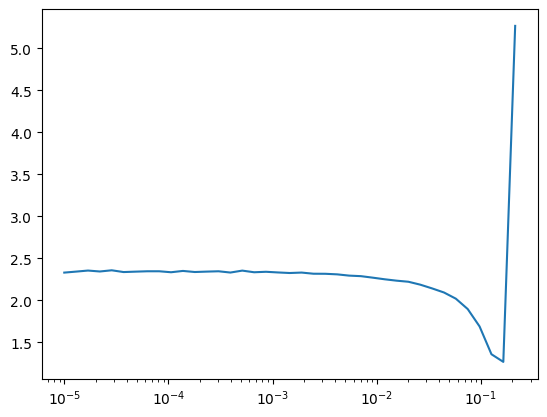

In [44]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [45]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.588,1.229,0,train
0.780,0.590,0,eval
0.819,0.487,1,train
0.827,0.467,1,eval
0.843,0.424,2,train
0.847,0.422,2,eval


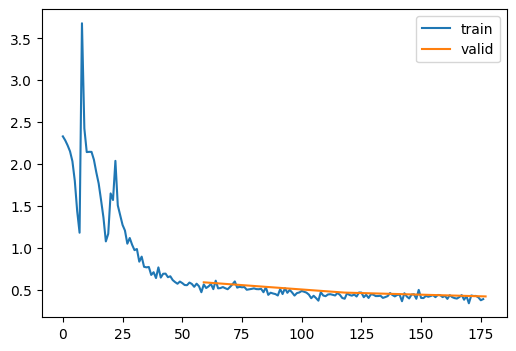

In [46]:
learn.fit(3)

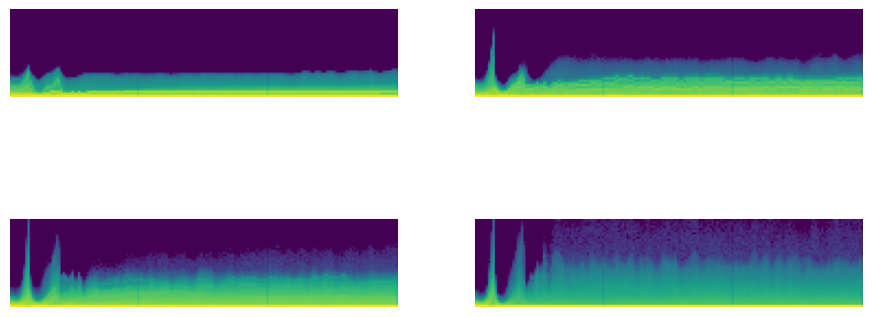

In [47]:
astats.color_dim()

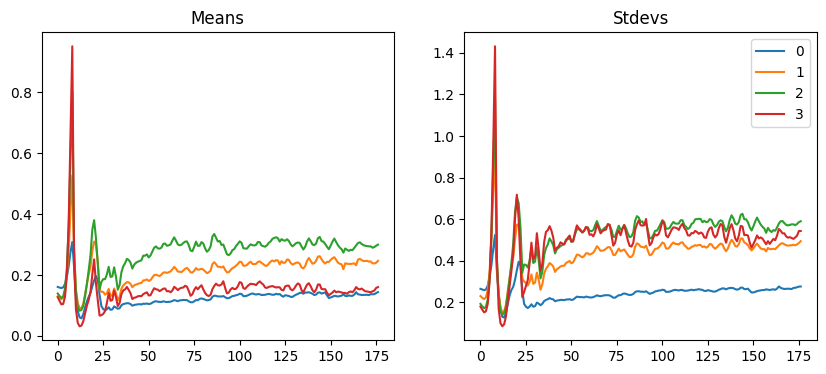

In [48]:
astats.plot_stats()

## Input normalization

In [49]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [50]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True):
        fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [51]:
def _norm(b):
    return (b[0] - xmean) / xstd, b[1]

norm = BatchTransformCB(_norm)

Normalizes the first element of the input tuple `b` by centering around `xmean` and scaling by `xstd`. `xmean` is the mean of the data, and `xstd` is the standard deviation. This ensures that the feature has a mean of 0 and a standard deviation of 1, which helps improve model performance and stability. The second element of `b` is returned unchanged.

accuracy,loss,epoch,train
0.547,1.397,0,train
0.749,0.666,0,eval
0.808,0.517,1,train
0.819,0.480,1,eval
0.842,0.432,2,train
0.838,0.439,2,eval


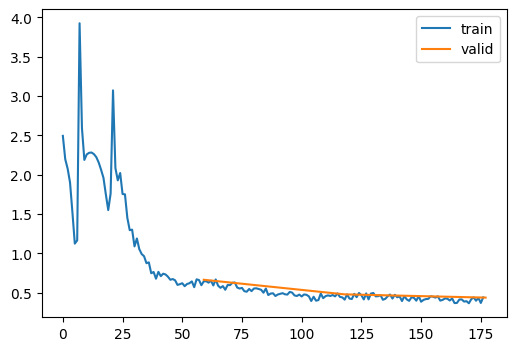

In [52]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

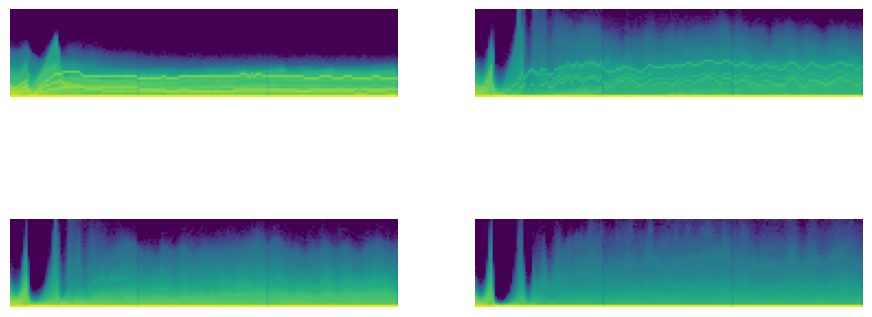

In [53]:
astats.color_dim()

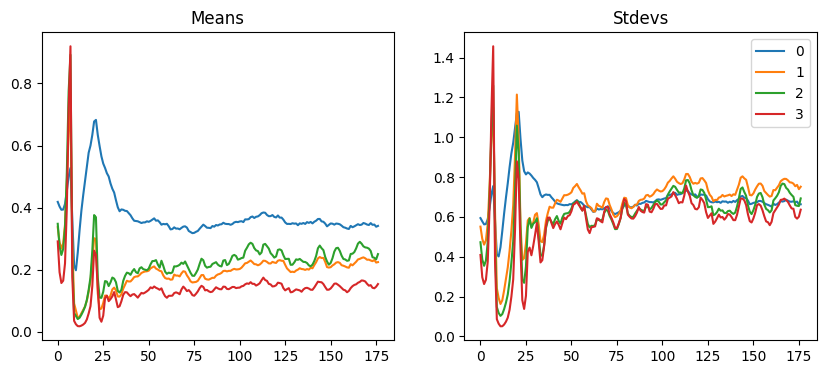

In [54]:
astats.plot_stats()

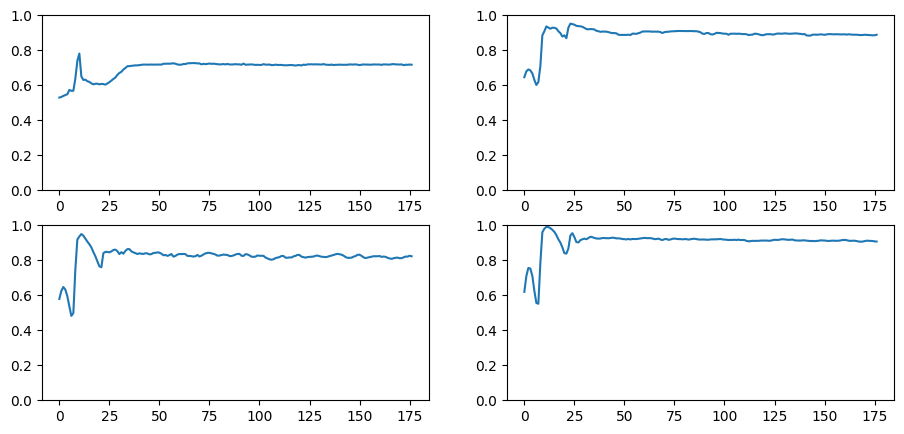

In [55]:
astats.dead_chart()

In [56]:
@inplace
def transformi(b):
    b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [57]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [58]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x -= self.sub
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x

## Leak (Leaky ReLU behavior):
- **Parameter**: `leak`
- **Function**: If `leak` is provided, the activation will use **Leaky ReLU** instead of the standard ReLU. Leaky ReLU allows a small, non-zero gradient for negative input values, preventing them from being completely "killed" as in regular ReLU.
  
  **Leaky ReLU**:
  $$
  f(x) =
  \begin{cases}
    x & \text{if } x > 0 \\
    \alpha x & \text{if } x \leq 0
  \end{cases}
  $$
  Where $\alpha = \text{leak}$, a small constant typically less than 1 (e.g., 0.01).


#### Subtraction (Offset adjustment):
- **Parameter**: `sub`
- **Function**: If `sub` is provided, a constant value is subtracted from the output after the activation (either ReLU or Leaky ReLU). This allows you to shift the output of the activation function. This can be useful for fine-tuning the activation range. By subtracting a constant value, you can lower the threshold for positive activations or allow some negative values to pass through. This is a way to center the activation output around a different value, potentially improving training dynamics for certain tasks.
  
  $$
  x = x - \text{sub}
  $$


#### Max Value Clamping (Upper bound control):
- **Parameter**: `maxv`
- **Function**: If `maxv` is provided, the activation output is clamped to a maximum value. This means that any values greater than `maxv` will be clipped to `maxv`. Clamping the output helps control the range of the activations, ensuring they don’t grow too large. This can stabilize training, especially in deep networks where large activations can lead to exploding gradients. It also provides a way to ensure bounded outputs in applications where the range is important.
  
  $$
  x = \min(x, \text{maxv})
  $$

In [59]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

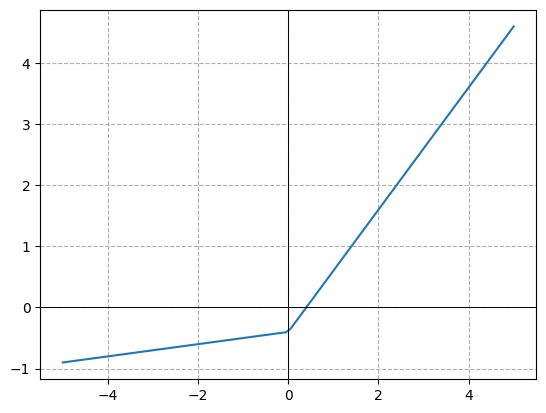

In [60]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [61]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, act())
    return res

In [62]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None:
        nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [63]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)):
        init.kaiming_normal_(m.weight, a=leaky)

In [64]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [65]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.774,0.625,0,train
0.846,0.420,0,eval
0.868,0.361,1,train
0.859,0.374,1,eval
0.880,0.325,2,train
0.868,0.361,2,eval


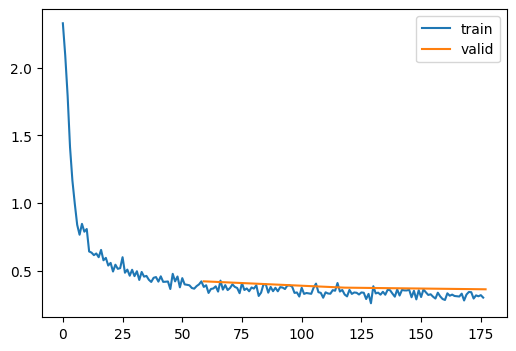

In [66]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

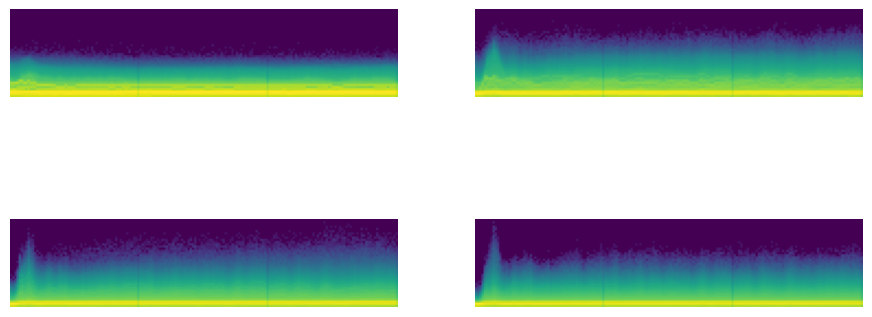

In [67]:
astats.color_dim()

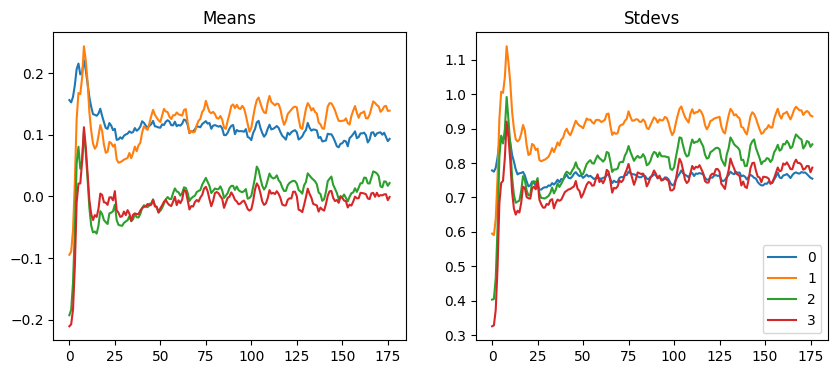

In [68]:
astats.plot_stats()

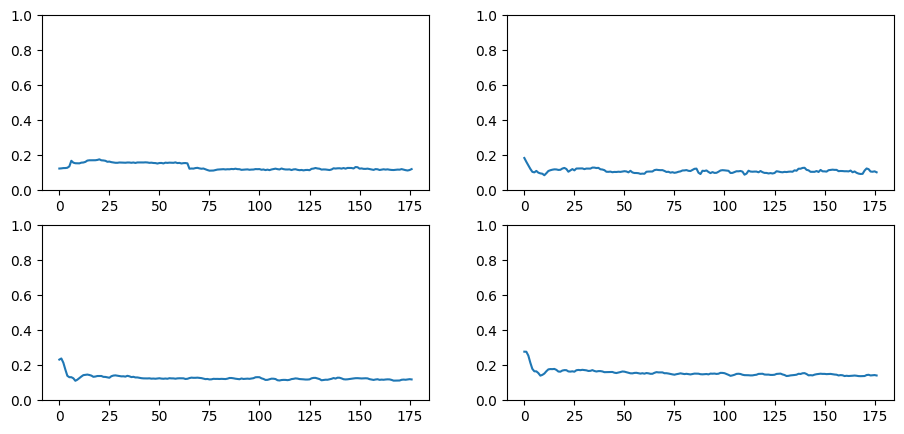

In [69]:
astats.dead_chart()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

#### LSUV Initialization Overview

How It Works

- Start with random weights for the entire network.
- For each layer:
    - Freeze all previously initialized layers.
    - Train only the current layer to produce outputs with unit variance.
    - Update the weights of the current layer.
- Repeat for subsequent layers until reaching the output layer.

```python
import torch
import torch.nn as nn
import torch.optim as optim

def lsuv_init(model):
    # Get input and output shapes
    x_shape = model[0].weight.shape
    y_shape = model[-1].weight.shape
    
    # Initialize weights randomly
    for layer in model:
        if isinstance(layer, nn.Conv2d):
            layer.weight.data.normal_(mean=0.0, std=1.0)
    
    # Normalize layers iteratively
    for i, layer in enumerate(model[:-1]):
        # Freeze previous layers
        for prev_layer in model[:i]:
            prev_layer.weight.requires_grad = False
        
        # Forward pass to get outputs
        x = torch.randn(x_shape[0], *x_shape[1:])
        for prev_layer in model[:i]:
            x = prev_layer(x)
        
        # Compute target variance
        target_var = 1.0 / len(model)
        
        # Backward pass to adjust current layer
        optimizer = optim.SGD([layer.weight], lr=1e-3)
        loss_fn = nn.MSELoss()
        
        for _ in range(100):  # Adjust number of iterations as needed
            optimizer.zero_grad()
            y = layer(x)
            loss = loss_fn(y.var(dim=0), torch.ones_like(y.var(dim=0)) * target_var)
            loss.backward()
            optimizer.step()
    
    # Unfreeze all layers
    for layer in model:
        layer.weight.requires_grad = True

# Example usage
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*32*32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 128*32*32)
        x = self.fc1(x)
        return x

model = SimpleNet()
lsuv_init(model)

print(model)

```

In [70]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

`_lsuv_stats(hook, mod, inp, outp)` is a function that collects mean and standard deviation of the activations (`outp`) from a particular layer (`mod`) during the forward pass of the model.
The hook stores these stats to adjust the layer parameters during initialization.

`lsuv_init` function:

`model`: The overall model being trained.

`m`: The current layer of the model.

`m_in`: The corresponding layer’s parameters (weights and bias) that will be adjusted.

`xb`: A mini-batch of input data used to initialize the layer

It attaches a hook to the layer, so that during the forward pass, the activations can be tracked. This is done by calling the `model(xb)` forward pass inside a 
`torch.no_grad()` block, which prevents gradients from being calculated. The core of the LSUV initialization is the loop that continues adjusting the bias and weights of the layer until the mean of the activations becomes close to zero and the standard deviation becomes close to one `abs(h.std - 1) > 1e-3` or `abs(h.mean) > 1e-3`.

**Bias adjustment**: `m_in.bias -= h.mean` shifts the bias to center the activations (move the mean closer to zero).
**Weight adjustment**: `m_in.weight.data /= h.std scales` the weights to bring the standard deviation of the activations closer to 1.
Once the loop finishes (i.e., when the activations are standardized), the hook is removed with `h.remove()`.

In [71]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [72]:
for ms in zip(relus,convs):
    print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [73]:
for ms in zip(relus,convs):
    lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.650,0,train
0.834,0.455,0,eval
0.863,0.377,1,train
0.854,0.395,1,eval
0.877,0.336,2,train
0.861,0.376,2,eval


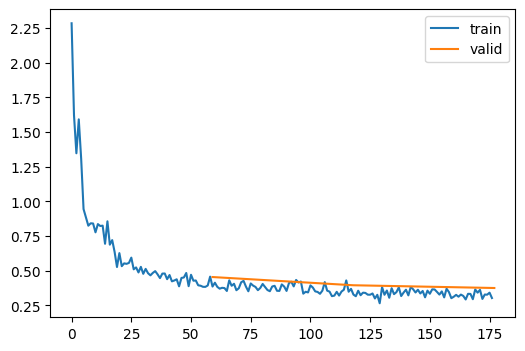

In [74]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

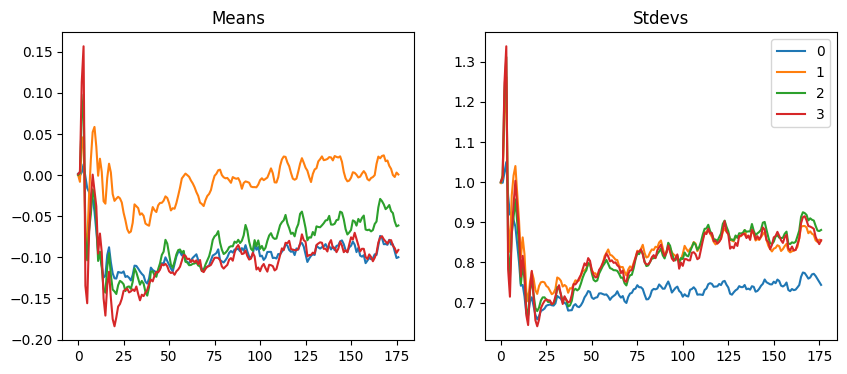

In [75]:
astats.plot_stats()

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

#### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

LayerNorm is a type of normalization technique commonly used in neural networks, particularly in transformer models. Here's an explanation of LayerNorm:

#### How It Works

1. **Calculation**:
   - For each feature (channel) in the input tensor:
     - Calculate the mean of all activations for that feature
     - Calculate the standard deviation of all activations for that feature
   - Subtract the mean from each activation
   - Divide by the standard deviation plus a small epsilon (for numerical stability)

2. **Learnable Parameters**: 
   - LayerNorm typically includes learnable parameters (gamma and beta) that allow for further adjustment of the normalized activations.

3. **Application**: 
   - Applied element-wise to each activation in the layer
   - The result is a normalized version of the input activations

#### Mathematical Representation

Given an input tensor `x` of shape `(batch_size, sequence_length, num_features)`:

1. Mean and Standard Deviation:
   ```
   mean = x.mean(dim=[1, 2], keepdim=True)
   std = x.std(dim=[1, 2], keepdim=True)
   ```

2. Normalization:
   ```
   normalized_x = (x - mean) / (std + epsilon)
   ```

3. Final Output:
   ```
   output = normalized_x * gamma + beta
   ```

#### Advantages

1. **Stability**: Helps prevent exploding/vanishing gradients
2. **Flexibility**: Works well with residual connections and attention mechanisms
3. **Efficiency**: Generally faster than batch normalization, especially in large models

#### Implementation in PyTorch

```python
from torch import nn

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-6, elementwise_affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(num_features))
            self.bias = nn.Parameter(torch.zeros(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        if self.elementwise_affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, x):
        u = x.sum(-1, keepdim=True)
        s = (x * x).sum(-1, keepdim=True)
        x = x * torch.rsqrt(s + self.eps)
        if self.elementwise_affine:
            x = x * self.weight + self.bias
        return x
```

Citations:

[1] https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#:~:text=Applies%20Layer%20Normalization%20over%20a%20mini%2Dbatch%20of%20inputs.&text=The%20mean%20and%20standard%2Ddeviation,is%20the%20dimension%20of%20normalized_shape%20.

[2] https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1

[3] https://stackoverflow.com/questions/70065235/understanding-torch-nn-layernorm-in-nlp

[4] https://docs.sambanova.ai/developer/latest/using-layernorm.html

[5] https://medium.com/@hunter-j-phillips/layer-normalization-e9ae93eb3c9c

[6] https://myscale.com/blog/optimize-neural-networks-pytorch-layernorm-step-by-step-guide/

[7] https://github.com/karpathy/llm.c/blob/master/doc/layernorm/layernorm.md

[8] https://medium.com/@florian_algo/batchnorm-and-layernorm-2637f46a998b

[9] https://pytorch.org/docs/stable/generated/torch.nn.functional.layer_norm.html

[10] https://discuss.pytorch.org/t/pytorch-doc-about-layernormalization-is-confusing/26977

In [76]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x * self.mult + self.add

In [77]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    
    if norm:
        layers.append(norm(nf))
    if act:
        layers.append(act())
    
    return nn.Sequential(*layers)

In [78]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None:
        nfs = [1,8,16,32,64]
    
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.781,0.606,0,train
0.846,0.421,0,eval
0.864,0.370,1,train
0.862,0.376,1,eval
0.881,0.322,2,train
0.867,0.363,2,eval


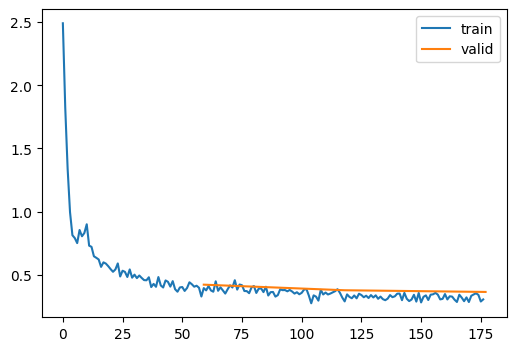

In [79]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

#### BatchNorm

How Batch Normalization Works

Normalization Process:

1. For each mini-batch of data, BN calculates the mean and standard deviation of the activations for each feature (channel) across all samples in the batch.

2. It then normalizes the activations by subtracting the mean and dividing by the standard deviation.

Learnable Parameters:

1. BN introduces two learnable parameters: gamma (scale factor) and beta (shift factor).

2. These parameters allow the network to adjust the normalized activations, compensating for potential information loss due to normalization.


In [80]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m, v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.800,0.550,0,train
0.833,0.536,0,eval
0.875,0.341,1,train
0.867,0.369,1,eval
0.886,0.306,2,train
0.868,0.365,2,eval


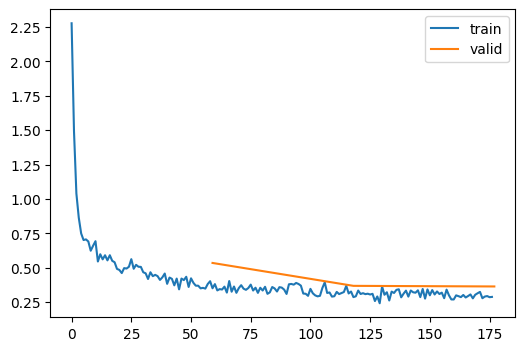

In [81]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](https://github.com/fastai/course22p2/blob/master/nbs/images/norms.png?raw=true)

## Towards 90%...

In [82]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.837,0.450,0,train
0.870,0.359,0,eval
0.882,0.319,1,train
0.867,0.365,1,eval
0.897,0.279,2,train
0.879,0.334,2,eval


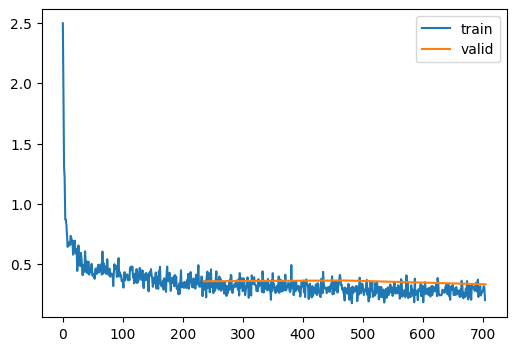

In [83]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.918,0.225,0,train
0.895,0.289,0,eval
0.922,0.211,1,train
0.900,0.281,1,eval


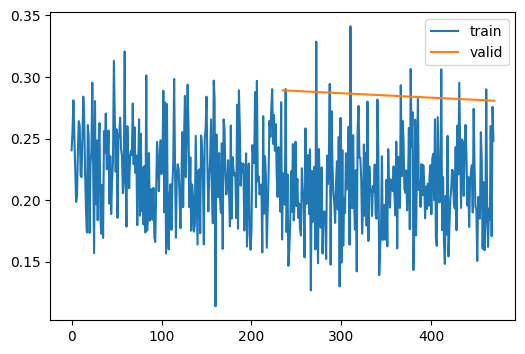

In [84]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)